# Data Cleaning for Tesla Stock Dataset


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
stock_data = pd.read_excel("combined_tesla.xlsx")
analyst_data = pd.read_excel("SELECTED_STOCKS.xlsx")
analyst_data = analyst_data.rename(columns = {"analytst": "analyst"})
analyst_data['date'] = pd.to_datetime(analyst_data['date']) #Chaning the date to pandas datetime format
stock_data = stock_data.rename(columns={'Date':'date'})
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data = stock_data[['date', 'Close', 'High', 'Low']] #Removing Irrelevant Columns
analyst_data = analyst_data[analyst_data["company_Name"] == "Tesla Inc"]

In [8]:
analyst_data = analyst_data.reset_index(drop=True)
analyst_data.index = analyst_data.index + 1
analyst_data.at[1284, 'price_target_before'] = 950
analyst_data.at[1284, 'price_target_after'] = 1300


In [9]:
analyst_data['price_target_before'] = pd.to_numeric(analyst_data['price_target_before'], errors='coerce')
analyst_data['price_target_after'] = pd.to_numeric(analyst_data['price_target_after'], errors='coerce')
analyst_data = analyst_data.dropna(subset=['price_target_after'])
analyst_data = analyst_data.sort_values(by='date', ascending=False)

In [10]:
tesla_data = pd.merge(left=analyst_data, right=stock_data, on='date', how='inner')

In [11]:
tesla_data.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,High,Low
0,2025-09-15,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,410.04,425.70,402.43
1,2025-08-04,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,309.26,312.12,303.00
2,2025-07-24,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,305.30,310.15,300.41
3,2025-07-24,Tesla Inc,TSLA,NaN,ANDRES SHEPPARD,Overweight,Overweight,355.0,355.0,305.30,310.15,300.41
4,2025-07-11,Tesla Inc,TSLA,NaN,MARK DELANEY,Neutral,Neutral,285.0,285.0,313.51,314.09,305.65


In [12]:
def days_to_hit_target(analyst_df, price_df):
    price_df = price_df.sort_values("date")

    def compute_days(row):
        start_date = row["date"]
        target = row["price_target_after"]

        future_prices = price_df[price_df["date"] > start_date].sort_values("date")

        if future_prices.empty:
            return np.nan

        if target >= row["Close"]:
            hit = future_prices[future_prices["High"] >= target]

        else:
            hit = future_prices[future_prices["Low"] <= target]

        if hit.empty:
            return np.nan

        hit_date = hit.iloc[0]["date"]
        return len(future_prices[future_prices["date"] <= hit_date])

    analyst_df["days_to_target"] = analyst_df.apply(compute_days, axis=1)
    return analyst_df

In [13]:
days_to_hit_target(tesla_data, stock_data).head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,High,Low,days_to_target
0,2025-09-15,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,410.04,425.70,402.43,NaN
1,2025-08-04,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,309.26,312.12,303.00,NaN
2,2025-07-24,Tesla Inc,TSLA,NaN,DANIEL IVES,Outperform,Outperform,500.0,500.0,305.30,310.15,300.41,NaN
3,2025-07-24,Tesla Inc,TSLA,NaN,ANDRES SHEPPARD,Overweight,Overweight,355.0,355.0,305.30,310.15,300.41,24.0
4,2025-07-11,Tesla Inc,TSLA,NaN,MARK DELANEY,Neutral,Neutral,285.0,285.0,313.51,314.09,305.65,NaN


* High means the highest price the stock traded at any moment on that day, and low means the vice versa. The function above determines if the stock has ever touched the analyst's price target on that day

### Visualizations

#### Days to Hit Price Target vs. Distance from Price at Initiation (Tesla)

In [22]:
import plotly.express as px
#Computing the absolute difference between analyst target and price at report date
tesla_data["pt_close_difference"] = (
    tesla_data["price_target_after"] - tesla_data["Close"]
).abs()

#Drop rows where the target was never hit
tesla_data_no_nan = tesla_data.dropna(subset=["days_to_target"])

#Filter to a 1-year investment horizon (252 trading days)
MAX_DAYS = 252
tesla_data_filtered = tesla_data_no_nan[
    tesla_data_no_nan["days_to_target"] <= MAX_DAYS
]

#Interactive scatter plot
fig = px.scatter(
    tesla_data_filtered,
    x="days_to_target",
    y="pt_close_difference",
    color="analyst",
    title="Days to Hit Price Target vs. Distance from Price at Initiation (Tesla)",
    labels={
        "days_to_target": "Trading days to reach price target",
        "pt_close_difference": "Absolute difference between price target and close price"
    },
    hover_data=[
        "date",
        "price_target_after",
        "Close"
    ]
)

fig.show()

This visualization examines how long it took for Tesla’s stock price to reach analysts’ revised price targets and how ambitious those targets were at the time they were issued.

Each point represents an analyst report. The x-axis shows the number of trading days required for the stock to hit the price target, while the y-axis measures the absolute difference between the analyst’s target and the stock’s closing price on the report date.

To align with standard sell-side practice, the analysis is restricted to price targets reached within one trading year (252 trading days), reflecting the typical 6–12 month investment horizon of analyst recommendations. Targets not reached within this window are treated as expired and excluded.

#### Average Time to Price Target vs. Target Aggressiveness by Analyst (Tesla)

In [23]:
# 1. Aggregate by analyst
analyst_average = (
    tesla_data_no_nan.groupby("analyst").agg(
        days_to_target=("days_to_target", "mean"),
        avg_difference=("pt_close_difference", "mean")
    )
    .reset_index()
)

# 2. Interactive scatter plot
fig = px.scatter(
    analyst_average,
    x="days_to_target",
    y="avg_difference",
    color="analyst",
    title="Average Time to Price Target vs. Target Aggressiveness by Analyst (Tesla)",
    labels={
        "days_to_target": "Average trading days to reach price target",
        "avg_difference": "Average absolute difference between price target and close price"
    },
    hover_data={
        "analyst": True,
        "days_to_target": ":.1f",
        "avg_difference": ":.2f"
    }
)

fig.show()


This visualization summarizes analyst behavior by comparing the average speed at which analysts’ price targets are reached with the average aggressiveness of those targets.

Each point represents an individual analyst. The x-axis shows the analyst’s average number of trading days required for Adobe’s stock price to reach their issued price targets, while the y-axis measures the average absolute gap between the price target and the stock’s closing price at the time of issuance.

Analysts positioned toward the lower-left tend to issue more conservative targets that are reached more quickly, while those toward the upper-right tend to issue more aggressive targets that take longer to materialize. Interactive hovering allows for detailed inspection of individual analyst performance.

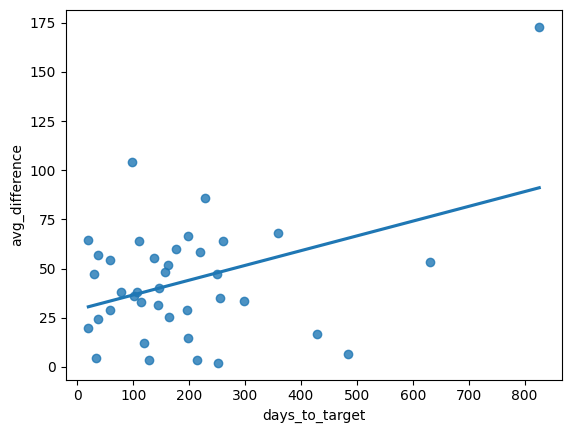

In [25]:
sns.regplot(analyst_average, x = "days_to_target", y = "avg_difference", ci = None)
plt.show()

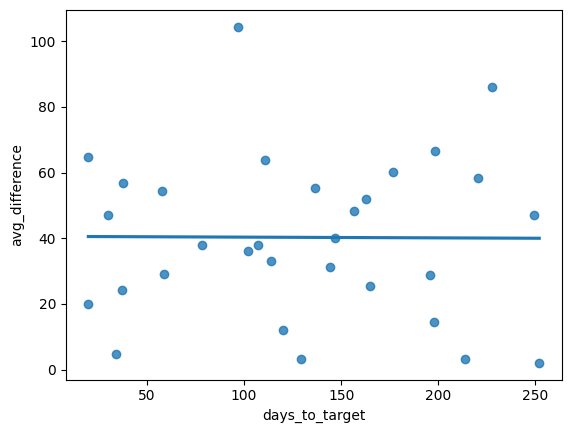

In [27]:
analyst_average_filtered = analyst_average[
    analyst_average["days_to_target"] <= 252
]
sns.regplot(analyst_average_filtered, x = "days_to_target", y = "avg_difference", ci = None)
plt.show()

* Full Sample: 
The first graph includes all analyst price targets, even those that took more than a year to be reached. In this full sample, there is a positive relationship between how aggressive an analyst’s price target is and how long it takes for the target to be hit. Analysts who set price targets further away from the current stock price generally see those targets reached more slowly. However, this pattern is influenced by a small number of extreme cases where targets were reached long after they were issued, when the original analyst view may no longer have been relevant.

* One-year Horizon: The second graph limits the analysis to price targets that were reached within one trading year. Once these long-horizon cases are removed, the relationship between target aggressiveness and time to target becomes much weaker and nearly flat. This suggests that within a typical analyst time horizon, more aggressive price targets do not consistently take longer to be realized. Instead, analysts with different styles see their targets reached over a similar range of time.

Together, the two graphs show that the stronger relationship observed in the full sample is largely driven by long-term outliers. When focusing on a realistic analyst horizon, the link between how ambitious a price target is and how quickly it is reached becomes much less pronounced.

#### Number of Price Targets that were never reached by each Analyst (Tesla)

In [28]:
never_hit_pt = tesla_data.groupby('analyst')['days_to_target'].apply(lambda x: x.isna().sum()).to_frame()
never_hit_pt_sorted = never_hit_pt.sort_values('days_to_target')

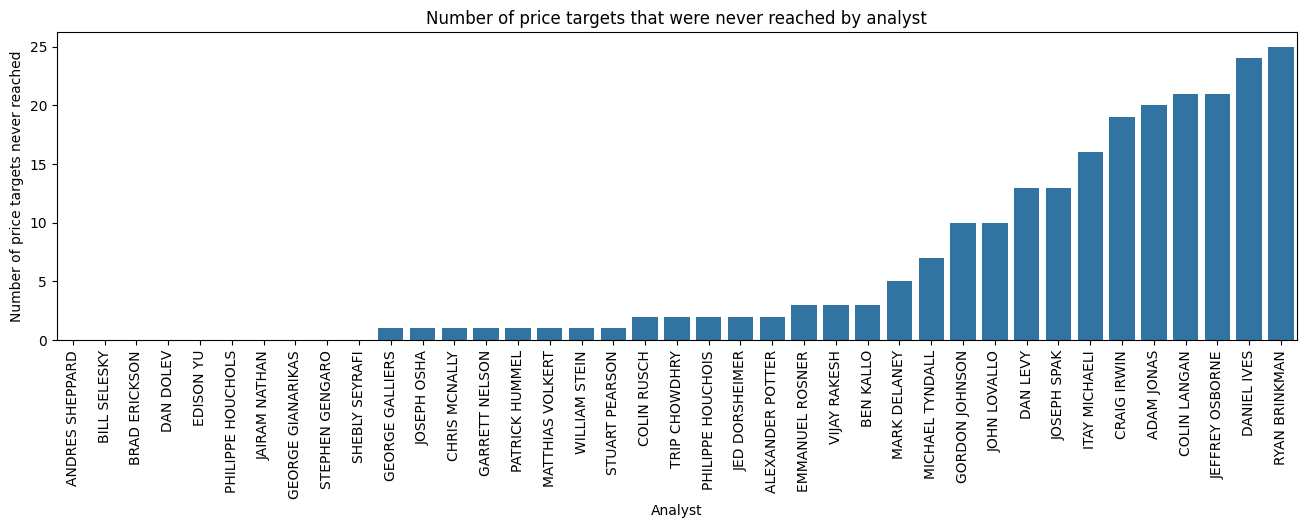

In [ ]:
plt.figure(figsize=(16, 4))
sns.barplot(
    data=never_hit_pt_sorted,
    x='analyst',
    y='days_to_target'
)

plt.xticks(rotation=90)
plt.ylabel('Number of price targets never reached')
plt.xlabel('Analyst')
plt.title('Number of Price Targets that were never reached by each Analyst')
plt.show()
